In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, minimize_scalar
from statistics import mean
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../data/processed/one_year_price.csv', index_col= 'Date', parse_dates= True)
days_trading = 252
r = 0.02
T = 1 # Time window for simulation
steps = len(data.iloc[:, 0])
Npaths = 10000

In [3]:
def CEV_path_simulation_mean(S, T, mu, sigma, gamma, steps, Npaths):
    z = np.random.normal(size = Npaths*steps)
    res = np.zeros((steps, Npaths))

    dt = T/steps
    sqrt_dt = dt ** 0.5
    S0 = S
    for path in range(Npaths):
        res[0, path] = S0
        for time in range(1, steps):
            S_time = res[time-1, path]
            S_temp = S_time + S_time * mu * dt + sigma * (S_time ** gamma) * z[path*steps + time] * sqrt_dt
            res[time, path] = S_temp

    paths_mean = res.mean(axis=1)

    return paths_mean

def CEV_objective(gamma, data, T, steps, Npaths):
    total_err = 0
    for stock_name in data.columns:
        S0 = data[stock_name].iloc[0]
        prices_mkt = data[stock_name].dropna().values
        log_ret = np.log(data[stock_name] / data[stock_name].shift(1)).dropna()
        mu = np.nanmean(log_ret) * 252
        sigma = np.nanstd(log_ret) * np.sqrt(252)

        prices_simu = CEV_path_simulation_mean(S0, T, mu, sigma, gamma, steps, Npaths)
        error = np.linalg.norm(prices_mkt - prices_simu, 2)
        total_err += error

    return total_err

def find_optimal_gamma(data, T, steps, Npaths):
    result = minimize_scalar(CEV_objective, bounds=(0, 1), args=(data, T, steps, Npaths), method='bounded')
    opt_gamma = result.x
    return opt_gamma

In [4]:
# Optimal gamma varies during different iterations, need further manipulation
opt_gamma = find_optimal_gamma(data, T, steps, Npaths)
print(f"Optimal gamma across all stocks: {opt_gamma}")

Optimal gamma across all stocks: 0.2982930888131938


In [5]:
random.seed(10)
result_list = []

for i in range(len(data.columns)):
    stock_name = data.columns[i]
    stock = data[[stock_name]]
    
    # Simulate half of the entire time window to measure performance
    num_term = 0.5
    dayEnd_vol = int(num_term*days_trading)

    returns_vol = (np.log(stock / stock.shift(1)))
    vol_daily = returns_vol.std()
    vol_daily = vol_daily.to_list()[0]
    vol_yearly = round(vol_daily * 252 ** 0.5,5)

    ret_yearly = (stock.iloc[-1,0]/stock.iloc[0,0] - 1)
    ret_yearly = round(ret_yearly, 5)

    S0 = stock.iloc[0]
    Npaths = 1
    prices_simu = CEV_path_simulation_mean(S0, T, ret_yearly, vol_yearly, opt_gamma, steps, Npaths)
    
    mt_simu = (prices_simu[-1]/prices_simu[0]-1)/len(prices_simu)*252
    mt_simu = round(mt_simu, 5)

    vt_return = (np.log(pd.Series(prices_simu)/pd.Series(prices_simu).shift(1)))
    vt_daily = vt_return.std()
    vt_simu = round(vt_daily * 252 ** 0.5,5)

    result_list.append([stock_name, ret_yearly, vol_yearly, mt_simu, vt_simu])

In [6]:
# Test Result, we can see that variance varies, weird
result_list

[['AAPL', 0.03746, 0.19397, 0.04327, 0.00493],
 ['AMZN', 0.76135, 0.29746, 1.10897, 0.00921],
 ['EEM', 0.06689, 0.14624, 0.08702, 0.01114],
 ['GLD', 0.11477, 0.11837, 0.11916, 0.00294],
 ['JNJ', 0.03956, 0.15595, 0.04263, 0.0046],
 ['JPM', 0.58283, 0.17107, 0.78935, 0.00493],
 ['SPY', 0.29126, 0.1145, 0.33787, 0.00157],
 ['TSLA', -0.09745, 0.47736, -0.08443, 0.01261]]

In [7]:
def CEV_path_simulation(S, T, mu, sigma, gamma, steps, Npaths):

    gaussian_increments = np.random.normal(size = Npaths*steps)
    res = np.zeros((steps, Npaths))

    dt = T/steps
    sqrt_dt = dt ** 0.5
    S0 = S
    for path in range(Npaths):
        res[0, path] = S0
        for time in range(1, steps):
            S_time = res[time-1, path]
            S_temp = S_time + S_time * mu * dt + sigma * (S_time ** gamma) * gaussian_increments[path*steps + time] * sqrt_dt
            res[time, path] = S_temp

    return res

[]

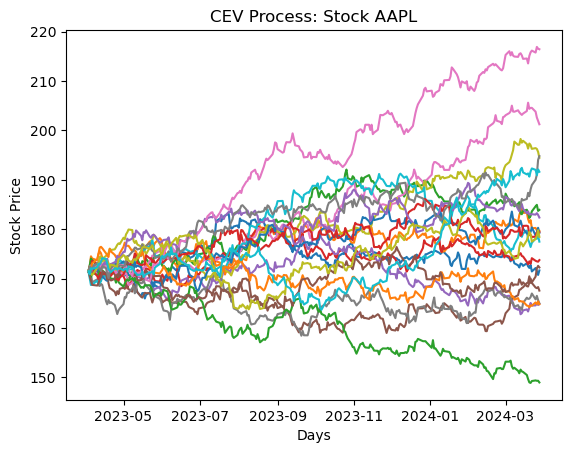

In [16]:
stock_name = data.columns[0]
stock = data[[stock_name]]

startstate = stock.iloc[-1,0]

prices_vol = stock
returns_vol = (np.log(prices_vol /prices_vol.shift(-1)))
vol_daily = returns_vol.std()
vol_daily = vol_daily.to_list()[0]
vol_yearly = round(vol_daily * 252 ** 0.5,5)


ret_yearly = (prices_vol.iloc[-1,0]/prices_vol.iloc[0,0] - 1)
ret_yearly = round(ret_yearly, 5)
    
mean = ret_yearly
vol = vol_yearly
Npaths = 20
prices_simu = CEV_path_simulation(startstate, T, mean, vol, 0.8, steps, Npaths)
prices_simu = pd.DataFrame(prices_simu, index= data.index)

plt.plot(prices_simu)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('CEV Process: Stock {}'.format(stock_name))
plt.plot()